In [81]:
import rootpy
import tensorflow as tf
import keras
import numpy as np
from sklearn.metrics import roc_curve, auc
import uproot
import matplotlib.pyplot as plt

In [296]:
arrays = uproot.open("allevts.root")['tree'].arrays(['H_pt',
                                                    'H_mass',
                                                    'V_pt',
                                                    'hJets_btagCSV_1',
                                                    'hJets_btagCSV_0',
                                                    "nAddJet_f",
                                                    "softActivityVH_njets5",
                                                    'Top1_mass_fromLepton_regPT_w4MET',                       
                                                    'V_mt',
                                                    'met_pt'
                                                    #'hJets_pt_0',
                                                    #"hJets_pt_1",
                                                    #"hJets_eta_0",
                                                    #"hJets_eta_1",
                                                    #"selLeptons_pt_0",
                                                    #"selLeptons_eta_0",
                                                    #"jjWPtBalance",
                                                    #"AddJets252p9_puid_leadJet_btagCSV"
                                                    ])

In [297]:
Xs = []
for i in arrays:
    Xs.append(arrays[i])
Xs = np.array(Xs, dtype=float).transpose()
Ys = uproot.open("allevts.root")['tree'].arrays('sig')['sig']
print Xs.shape
print Ys.shape

(1294128, 10)
(1294128,)


In [298]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random
X, y = shuffle(Xs, Ys, random_state=0)

new_idx = []
for i in y:
    if i < 0.5:
        if random.uniform(0, 1) > 0.1:
            new_idx.append(False)
        else:
            new_idx.append(True)
    else:
        new_idx.append(True)
X = X[new_idx]
y = y[new_idx]
print X.shape
print y.shape
print "Sig/bkg ratio:", sum(y)/len(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

(229179, 10)
(229179,)
Sig/bkg ratio: 0.482950008508633


In [299]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
import numpy
# fix random seed for reproducibility
numpy.random.seed()

In [300]:
# create model
model = Sequential()
model.add(Dense(20, input_dim=X_train.shape[-1], activation='relu', kernel_initializer='random_normal',
                bias_initializer='zeros'))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [301]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [302]:
weight = {0: 1.,
          1: 10.}
# Fit the model
#model.fit(X_train, y_train, epochs=100, batch_size=256, validation_split=0.2, class_weight=weight)
model.fit(X_train, y_train, epochs=100, batch_size=1024, validation_split=0.2)

Train on 146674 samples, validate on 36669 samples
Epoch 1/100
146674/146674 [==============================] - 4s 27us/step - loss: 0.8898 - acc: 0.6186 - val_loss: 0.5963 - val_acc: 0.6712
Epoch 2/100
146674/146674 [==============================] - 2s 12us/step - loss: 0.5855 - acc: 0.6854 - val_loss: 0.5682 - val_acc: 0.7000
Epoch 3/100
146674/146674 [==============================] - 1s 9us/step - loss: 0.5642 - acc: 0.7069 - val_loss: 0.5516 - val_acc: 0.7159
Epoch 4/100
146674/146674 [==============================] - 1s 8us/step - loss: 0.5462 - acc: 0.7250 - val_loss: 0.5387 - val_acc: 0.7341
Epoch 5/100
146674/146674 [==============================] - 1s 8us/step - loss: 0.5334 - acc: 0.7355 - val_loss: 0.5343 - val_acc: 0.7380
Epoch 6/100
146674/146674 [==============================] - 1s 8us/step - loss: 0.5244 - acc: 0.7432 - val_loss: 0.5173 - val_acc: 0.7481
Epoch 7/100
146674/146674 [==============================] - 1s 9us/step - loss: 0.5164 - acc: 0.7504 - val_loss:

146674/146674 [==============================] - 1s 9us/step - loss: 0.4351 - acc: 0.8039 - val_loss: 0.4357 - val_acc: 0.8010
Epoch 60/100
146674/146674 [==============================] - 1s 7us/step - loss: 0.4354 - acc: 0.8030 - val_loss: 0.4318 - val_acc: 0.8062
Epoch 61/100
146674/146674 [==============================] - 1s 7us/step - loss: 0.4353 - acc: 0.8032 - val_loss: 0.4311 - val_acc: 0.8064
Epoch 62/100
146674/146674 [==============================] - 1s 7us/step - loss: 0.4344 - acc: 0.8040 - val_loss: 0.4358 - val_acc: 0.8027
Epoch 63/100
146674/146674 [==============================] - 1s 7us/step - loss: 0.4364 - acc: 0.8028 - val_loss: 0.4387 - val_acc: 0.8029
Epoch 64/100
146674/146674 [==============================] - 1s 7us/step - loss: 0.4340 - acc: 0.8045 - val_loss: 0.4299 - val_acc: 0.8057
Epoch 65/100
146674/146674 [==============================] - 1s 7us/step - loss: 0.4353 - acc: 0.8039 - val_loss: 0.4315 - val_acc: 0.8052
Epoch 66/100
146674/146674 [=====

In [303]:
# evaluate the model
scores = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

45836/45836 [==============================] - 6s 123us/step

acc: 80.73%


In [304]:
traindictions = model.predict(X_train)
predictions = model.predict(X_test)

In [305]:
print len(predictions), len(y_test)

45836 45836


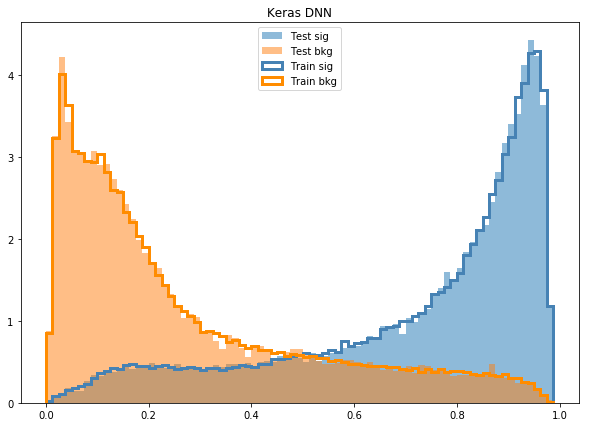

In [306]:
plt.figure(figsize=(10,7))
bins = np.arange(0,1,1/80.)
#plt.semilogy()
plt.hist(predictions, bins=bins, weights=y_test, alpha=0.5, normed=True, label="Test sig")
plt.hist(predictions, bins=bins, weights=1-y_test, alpha=0.5, normed=True, label="Test bkg")
plt.hist(traindictions, bins=bins, weights=y_train, normed=True, label="Train sig", histtype=u'step', lw=3, color='steelblue')
plt.hist(traindictions, bins=bins, weights=1-y_train, normed=True, label="Train bkg", histtype=u'step', lw=3, color='darkorange')
plt.title("Keras DNN")
plt.legend()
plt.show()

In [307]:
compare = uproot.open("bdt_output.root")['dataset/TestTree'].arrays(['classID', 'BDT', 'DNN'])
truth = compare['classID']
predBDT = compare['BDT']
predDNN = compare['DNN']
Tcompare = uproot.open("tmva_out.root")['dataset/TestTree'].arrays(['classID', 'DNN'])
truthTMVA = Tcompare['classID']
predTMVA = Tcompare['DNN']
print len(truthTMVA), len(predTMVA)

307744 307744


BDT Efficiency at 30%:  75.0 , at 10%: 47.0 , at 1%: 12.0
DNN Efficiency at 30%:  80.0 , at 10%: 52.0 , at 1%: 13.0
Keras DNN Efficiency at 30%:  89.0 , at 10%: 68.0 , at 1%: 23.0


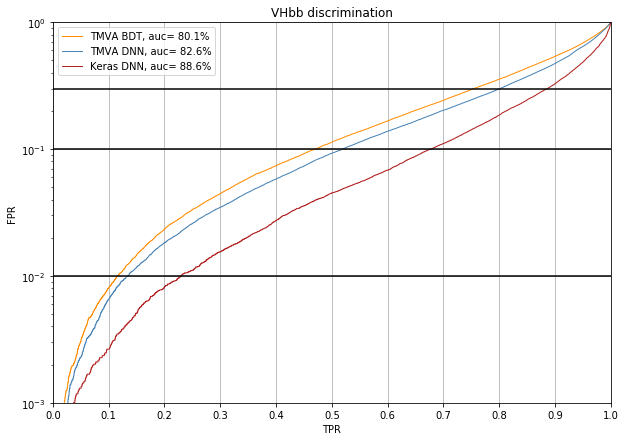

In [326]:
def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
        return idx, array[idx]

plt.figure(figsize=(10,7))

fpr, tpr, threshold = roc_curve(truth, 1-predBDT)
plt.plot(tpr, fpr, lw=1, label="TMVA BDT, auc= %.1f%%"%(auc(fpr,tpr)*100), c='darkorange')
ix3, m =  find_nearest(fpr, 0.3)
ix1, m =  find_nearest(fpr, 0.1)
ix01, m =  find_nearest(fpr, 0.01)
print "BDT Efficiency at 30%: ", round(tpr[ix3],2)*100, ", at 10%:", round(tpr[ix1],2)*100, ", at 1%:", round(tpr[ix01],2)*100
fpr, tpr, threshold = roc_curve(truthTMVA, 1-predTMVA)
plt.plot(tpr, fpr, lw=1, label="TMVA DNN, auc= %.1f%%"%(auc(fpr,tpr)*100), c='steelblue')
ix3, m =  find_nearest(fpr, 0.3)
ix1, m =  find_nearest(fpr, 0.1)
ix01, m =  find_nearest(fpr, 0.01)
print "DNN Efficiency at 30%: ", round(tpr[ix3],2)*100, ", at 10%:", round(tpr[ix1],2)*100, ", at 1%:", round(tpr[ix01],2)*100
fpr, tpr, threshold = roc_curve(y_test, predictions)
plt.plot(tpr, fpr, lw=1, label="Keras DNN, auc= %.1f%%"%(auc(fpr,tpr)*100), c='firebrick')
ix3, m =  find_nearest(fpr, 0.3)
ix1, m =  find_nearest(fpr, 0.1)
ix01, m =  find_nearest(fpr, 0.01)
print "Keras DNN Efficiency at 30%: ", round(tpr[ix3],2)*100, ", at 10%:", round(tpr[ix1],2)*100, ", at 1%:", round(tpr[ix01],2)*100

plt.xlim(0,1)
plt.ylim(0.001,1)
plt.title("VHbb discrimination")
plt.axhline(0.3, c='black')
plt.axhline(0.1, c='black')
plt.axhline(0.01, c='black')
plt.xticks(np.arange(0,1.1,0.1))
plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.grid()
plt.semilogy()
   
plt.savefig('/mnt/c/Users/novak/Desktop/vhbb.png')



22040
22040


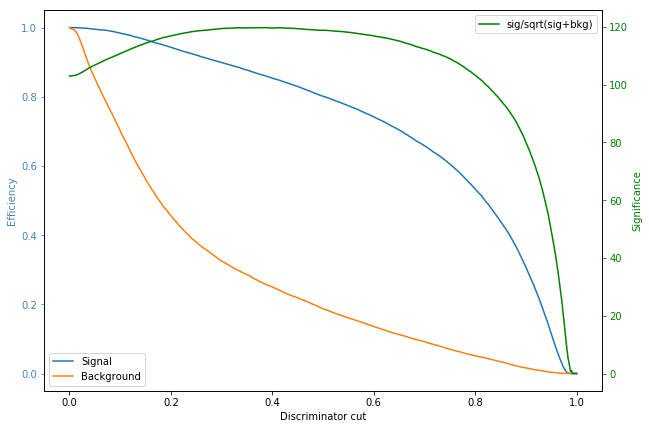

In [338]:
cuts = np.linspace(0,1,1000)
def sig_vals(y_test, predictions, norm=True):
    

    sig = predictions[y_test > 0.5]
    bkg = predictions[y_test < 0.5]
    print len(sig)
    tot = float(len(predictions))
    sig_eff, bkg_eff = [], []
    for c in cuts:
        if norm:
            sig_eff.append(np.sum(sig>c)/float(len(sig)))
            bkg_eff.append(np.sum(bkg>c)/float(len(bkg)))
        else:
            sig_eff.append(np.sum(sig>c))
            bkg_eff.append(np.sum(bkg>c))
    sig_eff = np.array(sig_eff)
    bkg_eff = np.array(bkg_eff)
    return sig_eff, bkg_eff

fig, ax1 = plt.subplots(figsize=(10,7))
ax1.set_ylabel('Efficiency', color='steelblue')
ax1.tick_params('y', colors='steelblue')
sig_eff, bkg_eff = sig_vals(y_test, predictions)
ax1.plot(cuts, sig_eff, label="Signal")
ax1.plot(cuts, bkg_eff, label="Background")
ax1.set_xlabel("Discriminator cut")
ax1.legend(loc='lower left')

ax2 = ax1.twinx()
sig_eff, bkg_eff = sig_vals(y_test, predictions, norm=False)
ax2.plot(cuts, sig_eff/np.sqrt(bkg_eff + sig_eff+0.00001), label="sig/sqrt(sig+bkg)", c='g')
ax2.set_ylabel('Significance', color='g')
ax2.tick_params('y', colors='g')
ax2.legend()

plt.show()
         
    
    

In [317]:
sig_eff, bkg_eff = sig_vals(y_test, predictions, norm=True)
sig_eff/np.sqrt(bkg_eff + sig_eff+0.00001)
t = 0
for s in sig_eff:
    t += s*s
print np.sqrt(t)

22040
7.673160388352868
